## observing how increasing epochs on autoencoder change the precision , recall ,F1 score

### using Diabetes dataset

In [ ]:
import sys
import os

# Define the path to your folder
folder_path = r"C:\Users\Tawfique\Thesis\Data_Augmentation\Models\AutoDiffusion"

# Add the folder to sys.path
sys.path.append(folder_path)
import numpy as np
#import process_edited as pce
import process_GQ as pce
import autoencoder as ae
import diffusion as diff
import TabDDPMdiff as TabDiff
import pandas as pd
import torch
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score


# strings_set = {'abalone', 'adult', 'Churn_Modelling','faults', 'indian_liver_patient', 
#                'insurance', 'News', 'Obesity', 'Shoppers', 'Titanic', 'wilt', 'Bean', 'nursery', 'Magic', 'HTRU'}
Model = 'AutoDiff'
dataset='diabetes'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'

recalls_bal_list = []
f1_bal_list = []
prec_bal_list=[]

for epoch_rng in range (0,21):
    # Read dataframe
    # print(filename)
    real_df = pd.read_csv(file_path)
    #real_df = real_df.drop('url', axis=1)
    # # Step 2: Inspect the data and check for class imbalance
    # # Assuming the last column is the label, and the rest are features
    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values  # Labels (binary classification)
    #  # Separate the minority class
    real_minortiy = real_df[y == 1]
    
    threshold = 0.01 # Threshold for mixed-type variables
    parser = pce.DataFrameParser().fit(real_minortiy, threshold)
    ################################################################################################################
    # Auto-encoder hyper-parameters
    device = 'cuda' #@param {'type':'string'}
    n_epochs = 1000+epoch_rng*200 #@param {'type':'integer'}
    eps = 1e-5 #@param {type:"number"}
    weight_decay = 1e-6 #@param {'type':'number'}
    maximum_learning_rate = 1e-2 #@param {'type':'number'}
    lr = 2e-4 #@param {'type':'number'}
    hidden_size = 250
    num_layers = 3
    batch_size = 50

    ds = ae.train_autoencoder(real_minortiy, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
    latent_features = ds[1].detach()

    # Convert to NumPy array
    array = latent_features.detach().cpu().numpy()
    forest_model = ForestDiffusionModel(array, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
    minority_fake = forest_model.generate(batch_size=len(real_minortiy))  # Adjust the batch size to create a balanced dataset
    sample=torch.tensor(minority_fake, dtype=torch.float32)
    gen_output = ds[0](sample, ds[2], ds[3])
    gen_df = pce.convert_to_table(real_minortiy, gen_output, threshold)
    selected_samples = gen_df.sample(n=min(100,gen_df.shape[0]), random_state=42)  # For reproducibility
    # Syn _df will be the dataset after augmentation
    syn_df = pd.concat([real_df, selected_samples], ignore_index=True)
    # augmented_df = pd.read_csv(syn_filename)
    augmented_df=syn_df

    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values 
    # Check and print the original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_dist_before = dict(zip(unique, counts))
    print(f"Class distribution before augmentation: {class_dist_before}")# Labels (binary classification)

    X_balanced = augmented_df.iloc[:, :-1].values  # Features
    y_balanced = augmented_df.iloc[:, -1].values  # Labels (binary classification)

    # Check and print the Augmented class distribution
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)
    

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    prec_orig = precision_score(y_test_orig, y_pred_orig)
    prec_bal = precision_score(y_test_orig, y_pred_bal)
    prec_bal_list.append(prec_bal)
    
    
    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)
    recalls_bal_list.append(recalls_bal)

    f1_orig = f1_score(y_test_orig, y_pred_orig)
    f1_bal = f1_score(y_test_orig, y_pred_bal)
    f1_bal_list.append(f1_bal)
    
    

    # Step 9: Print the performance metrics
    print(f"Precision score (original data): {prec_orig:.4f}")
    print(f"Precision score (generated data): {prec_bal:.4f}")
    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")
    print(f"F1 score (original data): {f1_orig:.4f}")
    print(f"F1 score (generated data): {f1_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


    print(f"Number of fake samples generated: {len(augmented_df)-len(real_df)}")

C:\Users\Tawfique\Thesis\Data_Augmentation\Datasets\diabetes.csv


  0%|          | 0/1000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8375
F1 score (original data): 0.6503
F1 score (generated data): 0.7791
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       151
           1       0.73      0.84      0.78        80

    accuracy                           0.84       231
   macro avg       0.82      0.84      0.82       231
weighted avg       0.84      0.84      0.84       231

Number of

  0%|          | 0/1200 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8250
F1 score (original data): 0.6503
F1 score (generated data): 0.7630
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      0.82      0.86       151
           1       0.71      0.82      0.76        80

    accuracy                           0.82       231
   macro avg       0.80      0.82      0.81       231
weighted avg       0.83      0.82      0.83       231

Number of

  0%|          | 0/1400 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8500
F1 score (original data): 0.6503
F1 score (generated data): 0.8047
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       151
           1       0.76      0.85      0.80        80

    accuracy                           0.86       231
   macro avg       0.84      0.86      0.85       231
weighted avg       0.86      0.86      0.86       231

Number of

  0%|          | 0/1600 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8375
F1 score (original data): 0.6503
F1 score (generated data): 0.7836
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       151
           1       0.74      0.84      0.78        80

    accuracy                           0.84       231
   macro avg       0.82      0.84      0.83       231
weighted avg       0.85      0.84      0.84       231

Number of

  0%|          | 0/1800 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8125
F1 score (original data): 0.6503
F1 score (generated data): 0.7692
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.89      0.84      0.87       151
           1       0.73      0.81      0.77        80

    accuracy                           0.83       231
   macro avg       0.81      0.83      0.82       231
weighted avg       0.84      0.83      0.83       231

Number of

  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8500
F1 score (original data): 0.6503
F1 score (generated data): 0.7953
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       151
           1       0.75      0.85      0.80        80

    accuracy                           0.85       231
   macro avg       0.83      0.85      0.84       231
weighted avg       0.86      0.85      0.85       231

Number of

  0%|          | 0/2200 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8500
F1 score (original data): 0.6503
F1 score (generated data): 0.7861
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       151
           1       0.73      0.85      0.79        80

    accuracy                           0.84       231
   macro avg       0.82      0.84      0.83       231
weighted avg       0.85      0.84      0.84       231

Number of

  0%|          | 0/2400 [00:00<?, ?it/s]

c:\Users\Tawfique\Thesis\Llama3_8B\Llama-3.1-8B-Instruct\LlamaENVpip\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8500
F1 score (original data): 0.6503
F1 score (generated data): 0.7861
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       151
           1       0.73      0.85      0.79        80

    accuracy                           0.84       231
   macro avg       0.82      0.84      0.83       231
weighted avg       0.85      0.84      0.84       231

Number of

  0%|          | 0/2600 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8625
F1 score (original data): 0.6503
F1 score (generated data): 0.8023
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.85      0.88       151
           1       0.75      0.86      0.80        80

    accuracy                           0.85       231
   macro avg       0.84      0.86      0.84       231
weighted avg       0.86      0.85      0.85       231

Number of

  0%|          | 0/2800 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8250
F1 score (original data): 0.6503
F1 score (generated data): 0.7811
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      0.85      0.87       151
           1       0.74      0.82      0.78        80

    accuracy                           0.84       231
   macro avg       0.82      0.84      0.83       231
weighted avg       0.85      0.84      0.84       231

Number of

  0%|          | 0/3000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8250
F1 score (original data): 0.6503
F1 score (generated data): 0.7630
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      0.82      0.86       151
           1       0.71      0.82      0.76        80

    accuracy                           0.82       231
   macro avg       0.80      0.82      0.81       231
weighted avg       0.83      0.82      0.83       231

Number of

  0%|          | 0/3200 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8250
F1 score (original data): 0.6503
F1 score (generated data): 0.7719
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      0.83      0.87       151
           1       0.73      0.82      0.77        80

    accuracy                           0.83       231
   macro avg       0.81      0.83      0.82       231
weighted avg       0.84      0.83      0.83       231

Number of

  0%|          | 0/3400 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8250
F1 score (original data): 0.6503
F1 score (generated data): 0.7543
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      0.81      0.85       151
           1       0.69      0.82      0.75        80

    accuracy                           0.81       231
   macro avg       0.80      0.82      0.80       231
weighted avg       0.83      0.81      0.82       231

Number of

  0%|          | 0/3600 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8125
F1 score (original data): 0.6503
F1 score (generated data): 0.7647
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.89      0.83      0.86       151
           1       0.72      0.81      0.76        80

    accuracy                           0.83       231
   macro avg       0.81      0.82      0.81       231
weighted avg       0.83      0.83      0.83       231

Number of

  0%|          | 0/3800 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8500
F1 score (original data): 0.6503
F1 score (generated data): 0.7907
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.84      0.88       151
           1       0.74      0.85      0.79        80

    accuracy                           0.84       231
   macro avg       0.83      0.85      0.83       231
weighted avg       0.85      0.84      0.85       231

Number of

  0%|          | 0/4000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8500
F1 score (original data): 0.6503
F1 score (generated data): 0.7771
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.82      0.86       151
           1       0.72      0.85      0.78        80

    accuracy                           0.83       231
   macro avg       0.81      0.84      0.82       231
weighted avg       0.84      0.83      0.83       231

Number of

  0%|          | 0/4200 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8375
F1 score (original data): 0.6503
F1 score (generated data): 0.7836
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       151
           1       0.74      0.84      0.78        80

    accuracy                           0.84       231
   macro avg       0.82      0.84      0.83       231
weighted avg       0.85      0.84      0.84       231

Number of

  0%|          | 0/4400 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8375
F1 score (original data): 0.6503
F1 score (generated data): 0.7882
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       151
           1       0.74      0.84      0.79        80

    accuracy                           0.84       231
   macro avg       0.83      0.84      0.83       231
weighted avg       0.85      0.84      0.85       231

Number of

  0%|          | 0/4600 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8500
F1 score (original data): 0.6503
F1 score (generated data): 0.7861
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       151
           1       0.73      0.85      0.79        80

    accuracy                           0.84       231
   macro avg       0.82      0.84      0.83       231
weighted avg       0.85      0.84      0.84       231

Number of

  0%|          | 0/4800 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8500
F1 score (original data): 0.6503
F1 score (generated data): 0.7907
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.84      0.88       151
           1       0.74      0.85      0.79        80

    accuracy                           0.84       231
   macro avg       0.83      0.85      0.83       231
weighted avg       0.85      0.84      0.85       231

Number of

  0%|          | 0/5000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution before augmentation: {0: 500, 1: 268}
Recall score (original data): 0.6625
Recall score (generated data): 0.8375
F1 score (original data): 0.6503
F1 score (generated data): 0.7929
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       151
           1       0.75      0.84      0.79        80

    accuracy                           0.85       231
   macro avg       0.83      0.85      0.84       231
weighted avg       0.85      0.85      0.85       231

Number of

In [ ]:
import matplotlib.pyplot as plt
epoch_list=[]
for epoch_val in range (1000,5001,200):
    epoch_list.append(epoch_val)


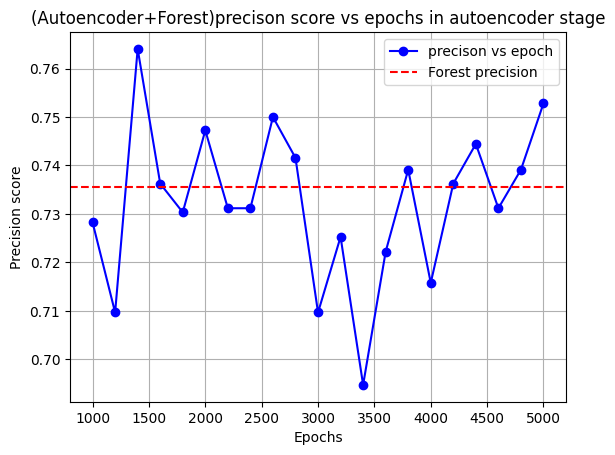

In [15]:
# Plotting
plt.plot(epoch_list, prec_bal_list, marker='o', linestyle='-', color='b', label='precison vs epoch')
plt.axhline(y=0.7356, color='r', linestyle='--', label='Forest precision')
plt.title('(Autoencoder+Forest)precison score vs epochs in autoencoder stage')  # Add a title
plt.xlabel('Epochs')  # Add label to X-axis
plt.ylabel('Precision score')  # Add label to Y-axis
plt.legend()  # Add legend
plt.grid(True)  # Add grid lines
plt.show()

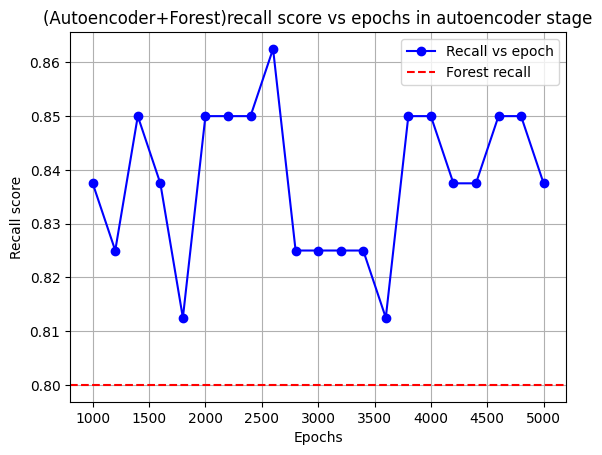

In [16]:
# Plotting
plt.plot(epoch_list, recalls_bal_list, marker='o', linestyle='-', color='b', label='Recall vs epoch')
plt.axhline(y=0.8, color='r', linestyle='--', label='Forest recall')
plt.title('(Autoencoder+Forest)recall score vs epochs in autoencoder stage')  # Add a title
plt.xlabel('Epochs')  # Add label to X-axis
plt.ylabel('Recall score')  # Add label to Y-axis
plt.legend()  # Add legend
plt.grid(True)  # Add grid lines
plt.show()

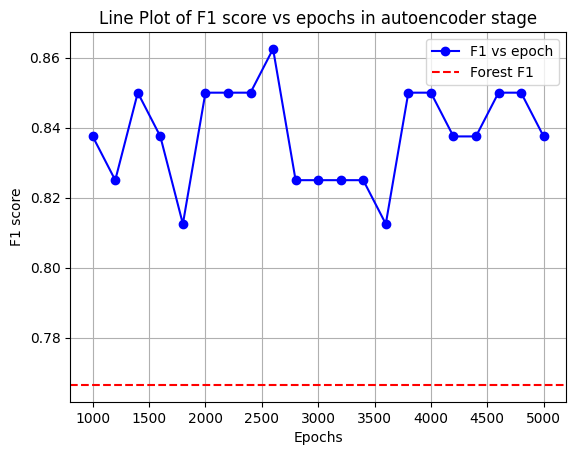

In [ ]:
# Plotting
plt.plot(epoch_list, f1_bal_list, marker='o', linestyle='-', color='b', label='F1 vs epoch')
plt.axhline(y=0.7665, color='r', linestyle='--', label='Forest F1')
plt.title('(Autoencoder+Forest)F1 score vs epochs in autoencoder stage')  # Add a title
plt.xlabel('Epochs')  # Add label to X-axis
plt.ylabel('F1 score')  # Add label to Y-axis
plt.legend()  # Add legend
plt.grid(True)  # Add grid lines
plt.show()